## Importing Library 

In [1]:
import os, sys, time, pathlib, os.path, argparse, glob
from zipfile import ZipFile
from io import BytesIO
from datetime import datetime

import tensorflow as tf
#gpus = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(gpus[1], 'GPU')

from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import normalize
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, concatenate, ReLU, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Conv2DTranspose, add, multiply, Activation, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import pandas as pd
import numpy as np
import cv2
import numpy
import pywt
import csv
import PIL
import imutils

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
from skimage.transform import resize

import random
tf.random.set_seed(123)

import keras.backend as K
# from keras.layers import Layer
import keras
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda, Input, Conv2D, Add
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.advanced_activations import ELU, LeakyReLU
#from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras.layers.noise import GaussianDropout
#from keras.layers import Input, Conv2D, Add

2023-05-08 11:17:25.017101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 11:17:25.236805: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-08 11:17:26.131765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.1/extras/CUPTI/lib64:/home/ajay/miniconda3/envs/tf/lib/
2023-05-08 11:17:26.131899: W tensorflow/stream_executor/platform/default/d

## Preparing Hyperparametrs 

In [2]:
RGB_H = 480
RGB_W = 640
RGB_C = 3 
Dep_H = 480
Dep_W = 640
Dep_C = 1 

EPOCHS =10
BATCH_SIZE = 8
#HEIGHT = 256
#WIDTH = 256
#LR = 0.001 #.0002
dropout_rate = 0.5
HEIGHT = 240
WIDTH = 320
INIT_LR = 1.0000e-05 #0.0001
TRAIN_PATH = "/home/ajay/nyu_data/data/nyu2_train.csv"
TEST_PATH = "/home/ajay/nyu_data/data/nyu2_test.csv"
#TRAIN_PATH_K = '/content/drive/MyDrive/Kitti_train/kitti/kitti_train.csv'
checkpoint_path = "acp.ckpt"

## Diode Dataset 

In [ ]:
annotation_folder = "/dataset/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

In [21]:
path = "val/indoors"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    #"mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df = pd.DataFrame(data)

#df = df.sample(frac=1, random_state=42)

In [22]:
df

image  \
0    val/indoors/scene_00019/scan_00183/00019_00183...   
1    val/indoors/scene_00019/scan_00183/00019_00183...   
2    val/indoors/scene_00019/scan_00183/00019_00183...   
3    val/indoors/scene_00019/scan_00183/00019_00183...   
4    val/indoors/scene_00019/scan_00183/00019_00183...   
..                                                 ...   
320  val/indoors/scene_00021/scan_00192/00021_00192...   
321  val/indoors/scene_00021/scan_00192/00021_00192...   
322  val/indoors/scene_00021/scan_00192/00021_00192...   
323  val/indoors/scene_00021/scan_00192/00021_00192...   
324  val/indoors/scene_00021/scan_00192/00021_00192...   

                                                 depth  
0    val/indoors/scene_00019/scan_00183/00019_00183...  
1    val/indoors/scene_00019/scan_00183/00019_00183...  
2    val/indoors/scene_00019/scan_00183/00019_00183...  
3    val/indoors/scene_00019/scan_00183/00019_00183...  
4    val/indoors/scene_00019/scan_00183/00019_00183...  
..                                                 ...  
320  val/indoors/scene_00021/scan_00192/00021_00192...  
321  val/indoors/scene_00021/scan_00192/00021_00192...  
322  val/indoors/scene_00021/scan_00192/00021_00192...  
323  val/indoors/scene_00021/scan_00192/00021_00192...  
324  val/indoors/scene_00021/scan_00192/00021_00192...  

[325 rows x 2 columns]

## Diode dataset pipeline

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True): #768, 1024
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y 

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map):  #, mask
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, (320,240))
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = np.load(depth_map).squeeze()

        #mask = np.load(mask)
        #mask = mask > 0

        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map) #, where=mask)

        #depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, (320,240))
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                #self.data["mask"][batch_id],
            )

        return x, y


In [5]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")
    Sa=6
    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(Sa, 3, figsize=(50, 50))
        for i in range(Sa):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(Sa, 2, figsize=(50, 50))
        for i in range(Sa):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


#visualize_samples = next(
#    iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH)))
#)
#visualize_depth_map(visualize_samples)

In [6]:
visualize_samples = next(iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH))))

2023-05-02 20:53:12.454770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 20:53:14.001030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15787 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-05-02 20:53:14.001998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14322 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


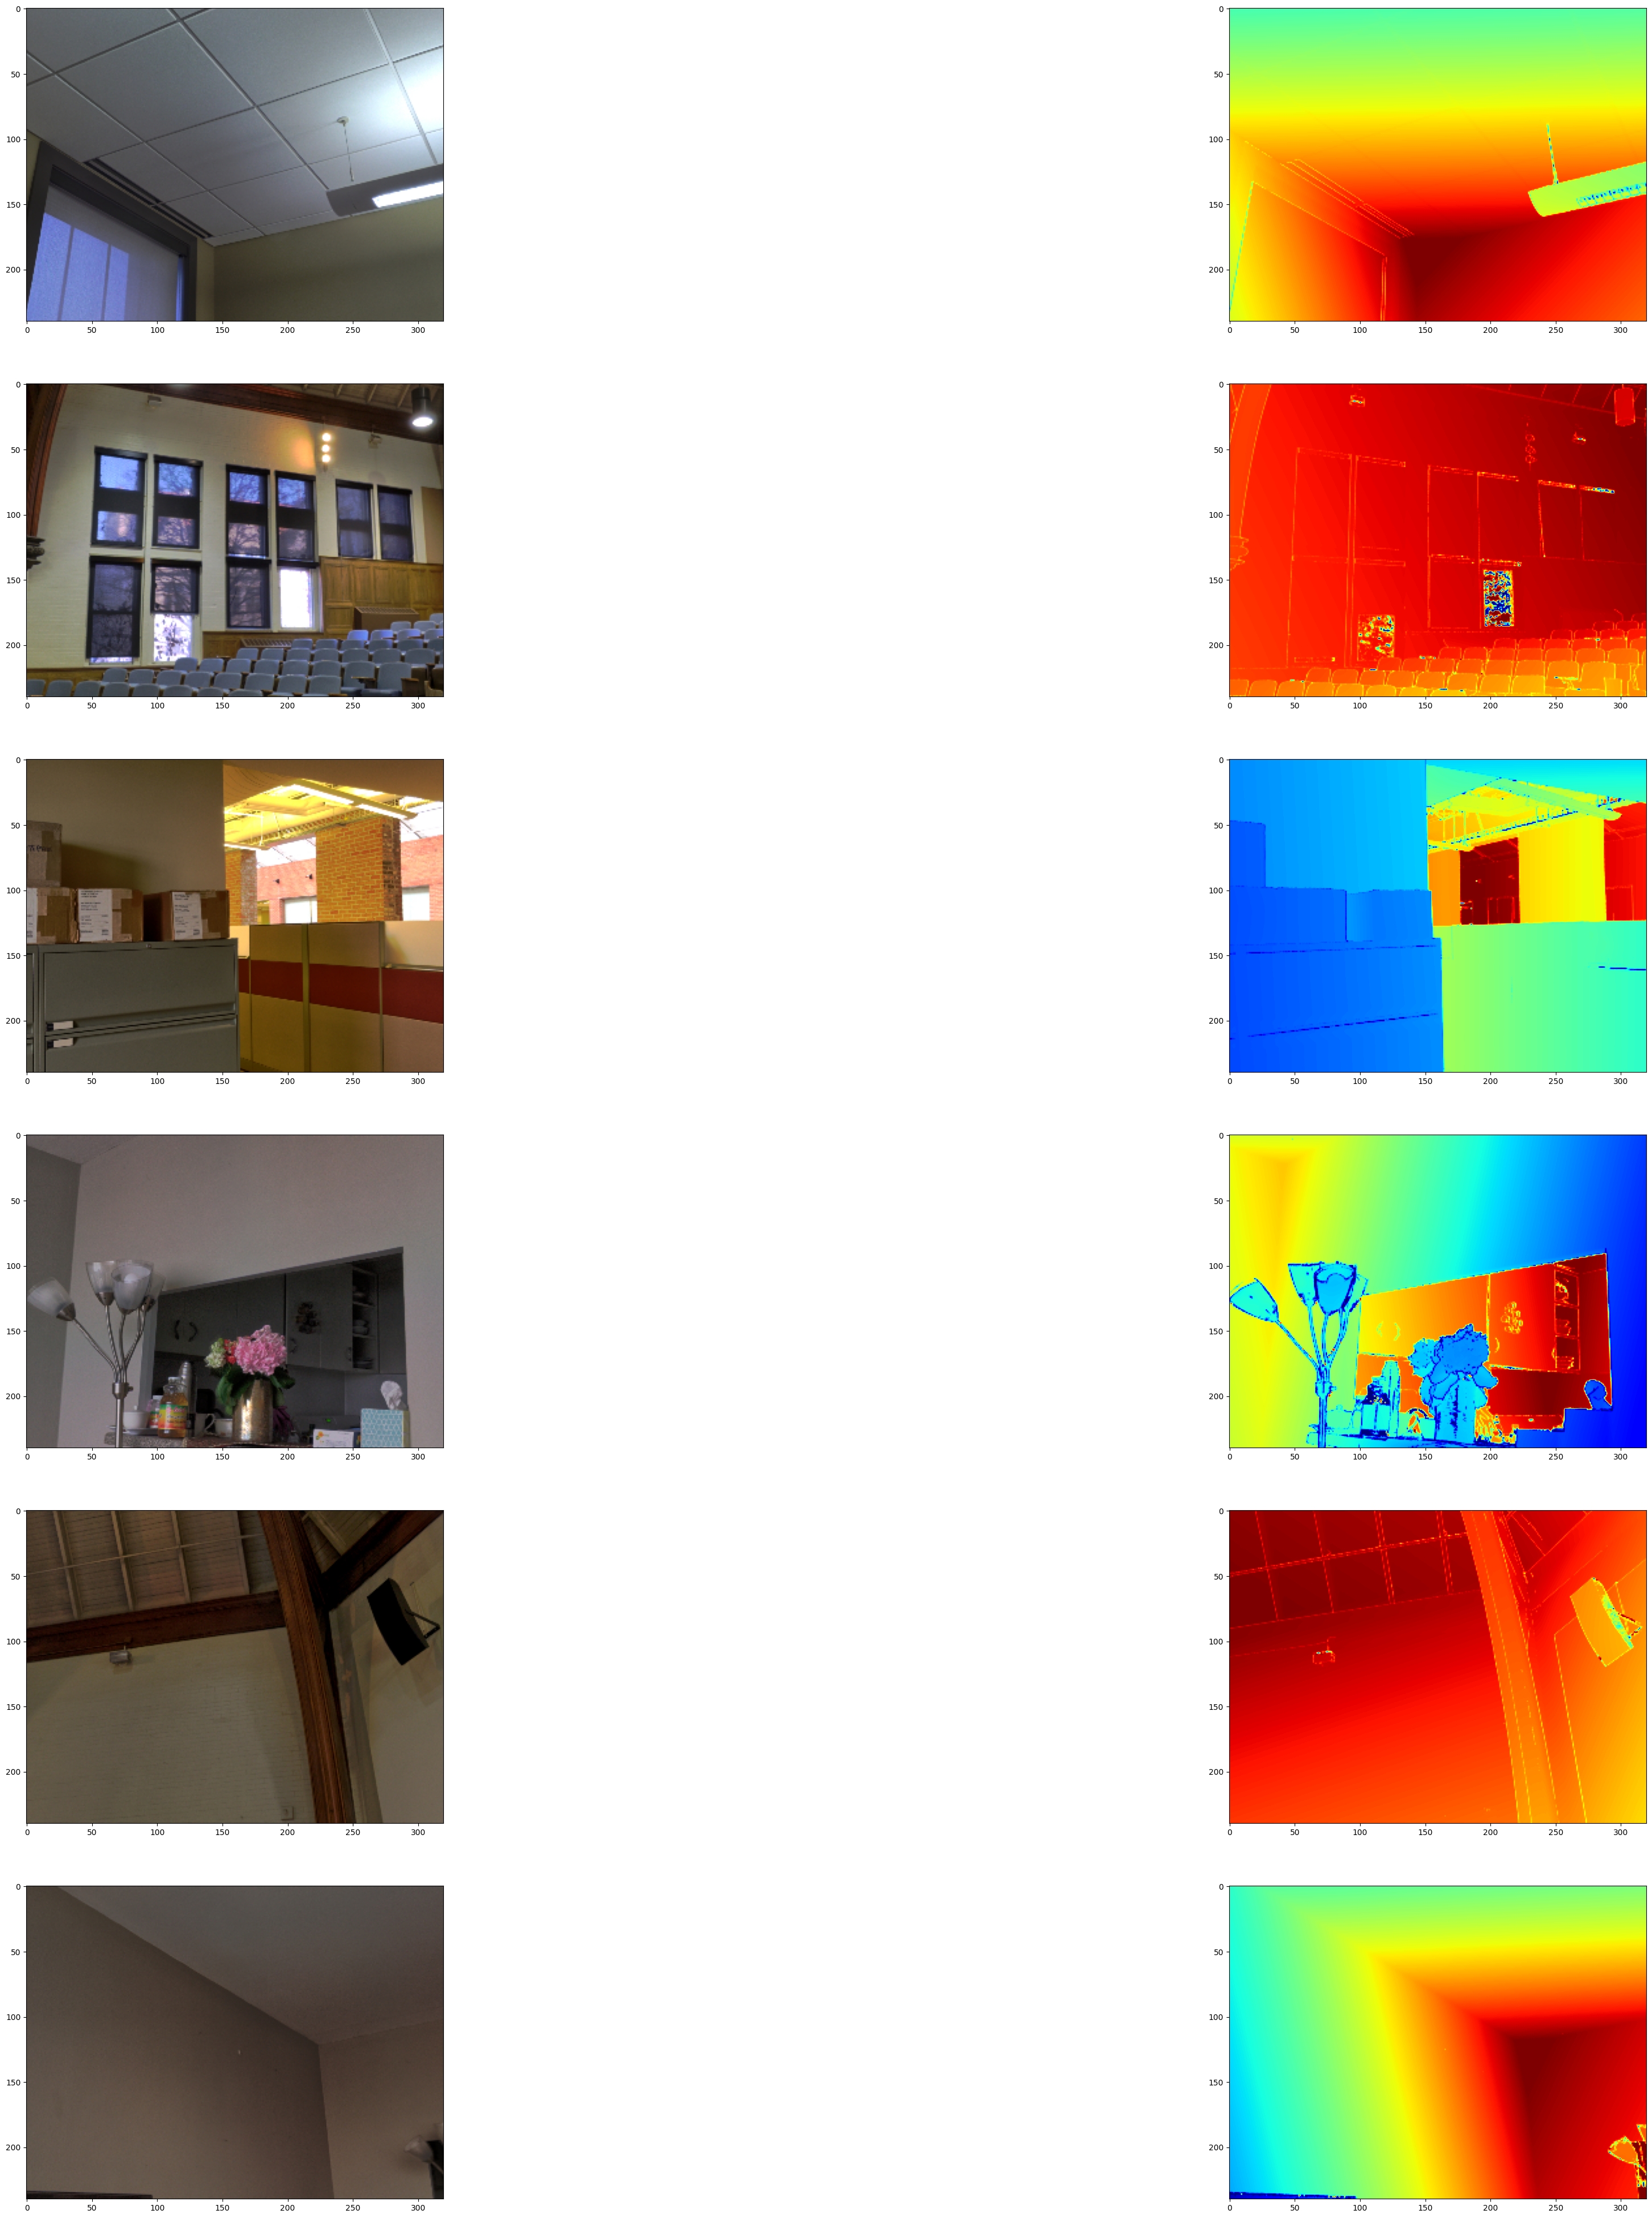

In [7]:
visualize_depth_map(visualize_samples)

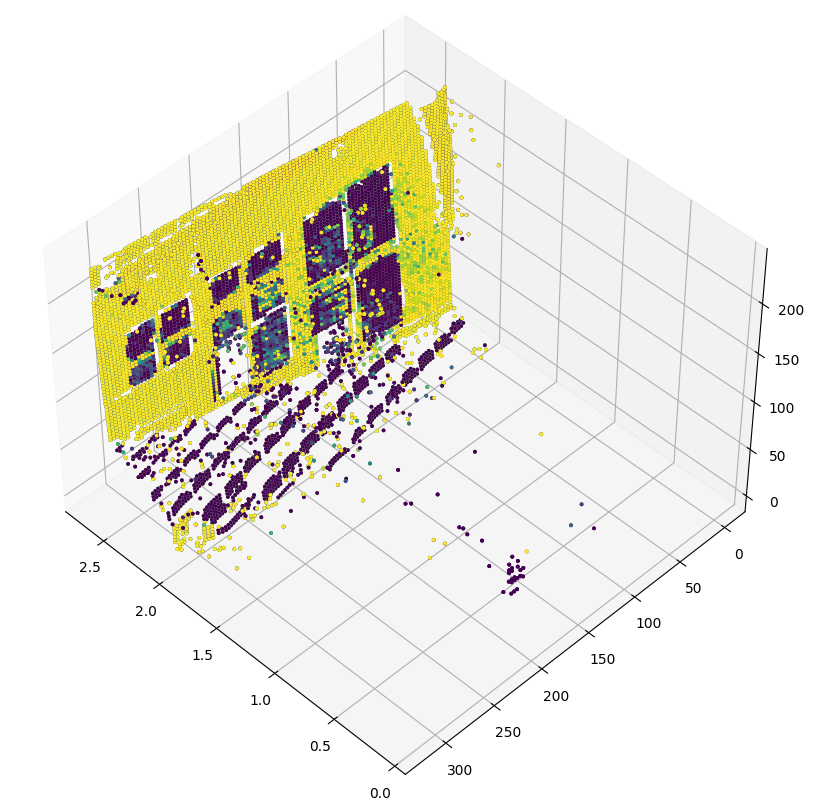

In [36]:
depth_vis = np.flipud(visualize_samples[1][1].squeeze())  # target
img_vis = np.flipud(visualize_samples[0][1].squeeze())  # input

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")

STEP = 3
for x in range(0, img_vis.shape[0], STEP):
    for y in range(0, img_vis.shape[1], STEP):
        ax.scatter(
            [depth_vis[x, y]] * 3,
            [y] * 3,
            [x] * 3,
            c=tuple(img_vis[x, y, :3] / 255),
            s=3,
        )
    ax.view_init(45, 135)

In [7]:
BATCH_SIZE
training_generator = DataGenerator(
    data=df[:260].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_generator = DataGenerator(
    data=df[260:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)

In [8]:
img ,dpt = next(iter(training_generator))

In [9]:
img.shape

(8, 240, 320, 3)

In [11]:
dpt.shape

(8, 240, 320, 1)

## Downloading NYU Dataset

In [1]:
!git clone https://gitlab.com/siddinc/new_depth.git ./data

Cloning into './data'...
remote: Enumerating objects: 65371, done.
fatal: write error: No space left on device47 MiB | 22.26 MiB/s   


In [3]:
def read_csv(csv_file_path):
    with open(csv_file_path, 'r') as f:
        csv_reader = csv.reader(f, delimiter=',')
        return [('./' + row[0], './' + row[1]) for row in csv_reader if len(row) > 0]
    
def train_val_split(train_paths, val_size):
    random.shuffle(train_paths)
    len_train_paths = len(train_paths)
    i = int(len_train_paths*(1.0 - val_size))
    train = train_paths[0:i]
    val = train_paths[i:len(train_paths)]
    return train, val

def load_train_paths(train_path):
    train_paths = read_csv(train_path)
    labels = {img_path: dm_path for img_path, dm_path in train_paths}
    x_paths = [img_path for img_path, dm in train_paths]
    x_train_paths, x_val_paths = train_val_split(x_paths, 0.3)
    
    partition = {
    'train': x_train_paths,
    'validation': x_val_paths
     }
    return partition, labels



In [4]:
# preprocessing the dataset

def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def preprocess_image(img_path, horizontal_flip=False):
    image = cv2.imread(img_path)
    image = imutils.resize(image, height=HEIGHT) #changed
    # image = image[:, 21:149].astype("float")
    image = image.astype("float")
    image = normalize_img(image)

    if horizontal_flip:
        image = cv2.flip(image, 1)
    return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
    depth_map = cv2.imread(depth_map_path)
    depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
    depth_map = imutils.resize(depth_map, height=HEIGHT) #changed
    # depth_map = depth_map[:, 21:149].astype("float")
    depth_map = depth_map.astype("float")
    depth_map = normalize_img(depth_map)

    if horizontal_flip:
        depth_map = cv2.flip(depth_map, 1)

    depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
    return depth_map

In [5]:
# data generator

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, batch_size=16, dim=(128,128), n_channels=3, shuffle=True, pred=False):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.pred = pred
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        if self.pred:
            X = self.__data_generation(list_IDs_temp)
            return X
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, self.dim[0], self.dim[1],self.n_channels))

        if not self.pred:
            y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1))

            for i, ID in enumerate(list_IDs_temp):
                res = random.choice([True, False])
                X[i,] = preprocess_image(ID, res)
                y[i,] = preprocess_depth_map(self.labels[ID], res)
            return X, y
        else:
            for i, ID in enumerate(list_IDs_temp):
                res = random.choice([True, False])
                X[i,] = preprocess_image(ID, res)
            return X

In [6]:
partition, labels = load_train_paths(TRAIN_PATH)
print(len(partition['train']), len(partition['validation']))
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

35481 15207


## Load KITTI Data and build data pipeline

In [16]:
def read_csvK(csv_file_path):
    with open(csv_file_path, 'r') as f:
        csv_reader = csv.reader(f, delimiter=',')
        return [(row[1], row[2]) for row in csv_reader if len(row) > 0]
        #return line

def train_val_split(train_paths, val_size):
    random.shuffle(train_paths)
    len_train_paths = len(train_paths)
    i = int(len_train_paths*(1.0 - val_size))
    train = train_paths[0:i]
    val = train_paths[i:len(train_paths)]
    return train, val

def load_train_pathsK(train_path):
    train_paths = read_csvK(train_path)
    labels = {img_path: dm_path for img_path, dm_path in train_paths}
    x_paths = [img_path for img_path, dm in train_paths]
    x_train_paths, x_val_paths = train_val_split(x_paths, 0.3)

    partition = {
                 'train': x_train_paths,
                 'validation': x_val_paths
                 }
    return partition, labels
  
def normalize_img(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def preprocess_image(img_path, horizontal_flip=False):
    image = cv2.imread(img_path)
    image = cv2.resize(image,[WIDTH,HEIGHT])
    image = image.astype("float")
    image = normalize_img(image)

    if horizontal_flip:
        image = cv2.flip(image, 1)
    return image

def preprocess_depth_map(depth_map_path, horizontal_flip=False):
    depth_map = cv2.imread(depth_map_path)
    depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
    depth_map = cv2.resize(depth_map,[WIDTH,HEIGHT])
    depth_map = depth_map.astype("float")
    depth_map = normalize_img(depth_map)

    if horizontal_flip:
        depth_map = cv2.flip(depth_map, 1)

    depth_map = np.reshape(depth_map, (depth_map.shape[0], depth_map.shape[1], 1))
    return depth_map

In [ ]:
partition, labels = load_train_pathsK(TRAIN_PATH_K)
print(len(partition['train']), len(partition['validation']))
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

### NYU

In [15]:
train_df = pd.read_csv("/home/ajay/nyu_data/data/nyu2_train.csv",header=None)
test = pd.read_csv("/home/ajay/nyu_data/data/nyu2_test.csv",header=None)

In [16]:
train_df = pd.read_csv("/home/ajay/nyu_data/data/nyu2_train.csv",header=None).rename(columns = {0:'image',1:'depth'})
test = pd.read_csv("/home/ajay/nyu_data/data/nyu2_test.csv",header=None).rename(columns = {0 : 'image',1:'depth'})

In [17]:
split = 0.8
height, width = 240, 240 #480, 480 # 240, 320

train_split = int(len(train_df)*split)
train = train_df[:train_split]
validation = train_df[train_split:]

In [18]:
len(train), len(validation) ,len(test)

(40550, 10138, 654)

In [19]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, shuffle=False, dim=(320,320)):
        np.random.seed(43)
        self.df = dataframe
        self.height, self.width = dim
        self.shuffle = shuffle
        self.batch_size = batch_size
        # unique set of RGB images
        self.ids = dataframe['image'].unique()
        # Map the image with depth maps
        self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
  
    def __getitem__(self,index):
        idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size] # select the batch of pair indexes 
        flip = np.random.choice([True, False])  # randomly select whether to flip the image
        query_imgs = [self.ids[idx] for idx in idxs]  # select the image id's for the above indexes
        target_imgs = [self.imgtodpth[img] for img in query_imgs]  # select corresponding depth pair for the image
        processed_query_img = self._preprocess_image(query_imgs, flip) # preprocess the image
        processed_depth_img = self._preprocess_depth(target_imgs, flip)  # preprocess the depth map
        return processed_query_img, processed_depth_img

    def _preprocess_image(self,images, flip):
        # placeholder for storing the processed images
        processed = []
        sze=240
        for img in images:
            # resize the image to 640x480
            resized_img = cv2.resize(cv2.imread("/home/ajay/nyu_data/" + img),(self.height,self.width)).astype(np.float32)
            # normalize the image to {0,1}
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            # flip the image horizontally
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            processed.append(scaled_img)
        return np.array(processed)

    def _preprocess_depth(self,images, flip):
        # placeholder for storing the processed depth maps
        processed = []
        sze=240
        for img in images:
            # resize the depth map to 320x240
            resized_img = cv2.resize(cv2.cvtColor(cv2.imread("/home/ajay/nyu_data/"+ img), cv2.COLOR_BGR2GRAY),(self.height,self.width)).astype(np.float32)
            # normalize it to range {0,1}
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            # flip the image horizontally
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
                # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
            scaled_img = np.expand_dims(scaled_img, axis=-1)
            # finally append the image
            processed.append(scaled_img)
        return np.array(processed)   

In [20]:
train_generator = DataGenerator(train, batch_size=32, shuffle=False, dim=(320,320))
val_generator = DataGenerator(validation, batch_size=32, shuffle=False, dim=(320,320))
test_generator = DataGenerator(test, batch_size=32, shuffle=False, dim=(320,320))
print(len(train_generator), len(val_generator),len(test_generator)) 

1267 316 20


In [21]:
images,depths = next(iter(train_generator))
print(images.shape, depths.shape)

(32, 320, 320, 3) (32, 320, 320, 1)


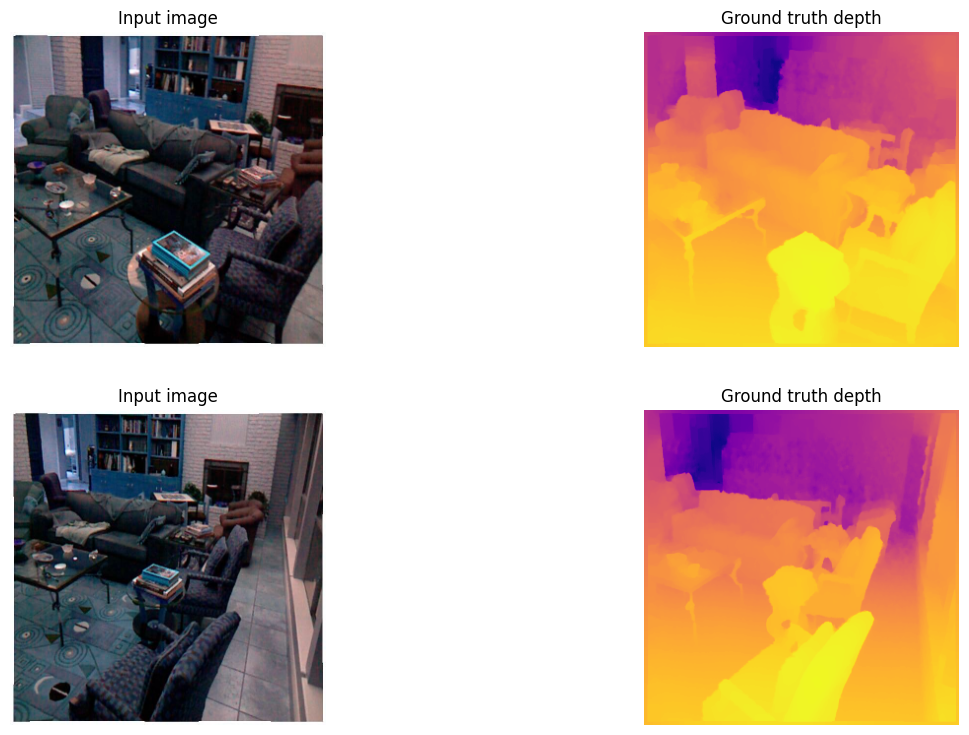

In [22]:
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
    image = images[i]
    depth = depths[i].squeeze(-1)
    plt.subplot(221+i)
    plt.axis('off')
    plt.imshow(image)
    plt.title('Input image')
    plt.subplot(222+i)
    plt.axis('off')
    plt.imshow(depth,cmap=plt.get_cmap(cmap))
    plt.title('Ground truth depth')

## Defining Loss Function 

In [31]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

def loss_function(y_true, y_pred):
    theta=0.1
    maxDepthVal=1000.0/10.0
    LapFilter = K.constant([[[[0]], [[-1 ]], [[0 ]]], [[[-1]], [[5 ]], [[-1 ]]], [[[0 ]], [[-1 ]], [[0 ]]]])
    #Cosine distance loss
    #l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
    c = 0.2 * tf.reduce_max(abs_error)
    berHu_loss1 = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
    l_depth = K.mean(berHu_loss1)
    # edge loss for sharp edges
    #dy_true, dx_true = tf.image.image_gradients(y_true)
    #dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    #l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
    s_true  = tf.image.sobel_edges(y_true)
    s_pred  = tf.image.sobel_edges(y_pred)
    l_edges = K.mean(K.mean(K.abs((s_pred[...,0]/4+0.5) - (s_true[...,0]/4+0.5)) + K.abs((s_pred[...,1]/4+0.5) - (s_true[...,1]/4+0.5)), axis=-1))
    # structural similarity loss
    inputChannels = K.reshape(K.ones_like(y_true[0,0,0,:]),(1,1,-1,1))
    filt = LapFilter * inputChannels
    LapTrue = K.depthwise_conv2d(y_true,filt, padding='same' ) 
    LapTrue =tf.clip_by_value(LapTrue, clip_value_min=0.0, clip_value_max=1.0) 
    l_ssim = K.clip((1 - tf.image.ssim(LapTrue, y_pred, maxDepthVal)) * 0.5, 0, 1)
    #l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 1, 0, 1)

    # weightage
    w1, w2, w3 = 1.0, 1.0, 0.1
    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))



In [32]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    return conv

In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True): 
    
    FILTER_NUM = 64 
    FILTER_SIZE = 3 
    UP_SAMP_SIZE = 2 
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
   
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8) #Conv2DTranspose
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
 
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128) # size=1/input_img[2],padding="same"
    conv_final = layers.BatchNormalization(axis=3)(conv_final)              # no
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel    no

    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    #print(model.summary())
    return model

In [22]:
from datetime import datetime
input_img = (320,320, 3)
model = UNet(input_img, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('ucp51.h5', save_best_only=True, verbose=1)

#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 20
    base_lr =  0.0002
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

csv_log51 = tf.keras.callbacks.CSVLogger('my_log51.csv',separator = ',',append=False)

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint ,early_stop,csv_log51] #reduce_lr, early_stopping]
#model.CompileAndSummarizeModel(model = model)
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
start=datetime.now()
history = model.fit(train_generator, validation_data=val_generator, epochs= 10 ,callbacks=callbacks)
stop=datetime.now()
print(stop-start)
model.save('unet51.h5')


Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/10


2023-04-24 23:49:07.820364: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/loss_function/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5068/5068 [==============================] - ETA: 0s - loss: 0.0599 - accuracy_function: 0.6994
Epoch 1: val_loss improved from inf to 0.05628, saving model to ucp51.h5
5068/5068 [==============================] - 1742s 342ms/step - loss: 0.0599 - accuracy_function: 0.6994 - val_loss: 0.0563 - val_accuracy_function: 0.7121 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019.
Epoch 2/10
5068/5068 [==============================] - ETA: 0s - loss: 0.0521 - accuracy_function: 0.7460
Epoch 2: val_loss improved from 0.05628 to 0.05484, saving model to ucp51.h5
5068/5068 [==============================] - 1744s 344ms/step - loss: 0.0521 - accuracy_function: 0.7460 - val_loss: 0.0548 - val_accuracy_function: 0.7198 - lr: 1.9000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00018.
Epoch 3/10
5068/5068 [==============================] - ETA: 0s - loss: 0.0476 - accuracy_function: 0.7765
Epoch 3: val_loss did not improve from 0.05484
5068/5068 [====

## Utilities- standard functions 

In [23]:
def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format
def db4_dwt(x):
    """
    channels_last
    :param x: [samples, widht, height, channels]
    :return:
    """
    arr = list()
    # for img in x:
    coeffs2 = pywt.dwt2(x[:,:,:,:], 'haar') #haar #db4
    LL, (LH, HL, HH) = coeffs2

    return K.concatenate([LL], axis=-1)

def db4_iwt(x):
    """
    channels_last
    :param x: [samples, widht, height, channels]
    :return:
    """
    arr = numpy.array()
    for img in x:
        recon = pywt.idwt2(img, 'haar')
        np.append(arr, recon)

    return K.concatenate(arr, axis=-1)



def dwt(x, data_format='channels_last'):

    """
    DWT (Discrete Wavelet Transform) function implementation according to
    "Multi-level Wavelet Convolutional Neural Networks"
    by Pengju Liu, Hongzhi Zhang, Wei Lian, Wangmeng Zuo
    https://arxiv.org/abs/1907.03128
    """

    if data_format == 'channels_last':
        # [all samplesL, width, height, neurons]
        x1 = x[:, 0::2, 0::2, :]  # x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :]  # x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :]  # x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :]  # x(2i, 2j)

    elif data_format == 'channels_first':
        x1 = x[:, :, 0::2, 0::2]  # x(2i−1, 2j−1)
        x2 = x[:, :, 1::2, 0::2]  # x(2i, 2j-1)
        x3 = x[:, :, 0::2, 1::2]  # x(2i−1, 2j)
        x4 = x[:, :, 1::2, 1::2]  # x(2i, 2j)

    x_LL = x1 + x2 + x3 + x4
    x_LH = -x1 - x3 + x2 + x4
    x_HL = -x1 + x3 - x2 + x4
    x_HH = x1 - x3 - x2 + x4

    if data_format == 'channels_last':
        return K.concatenate([x_LL, x_LH, x_HL, x_HH], axis=-1)
    elif data_format == 'channels_first':
        return K.concatenate([x_LL, x_LH, x_HL, x_HH], axis=1)


def iwt(x, data_format='channels_last'):
    """
    IWT (Inverse Wavelet Transfomr) function implementation according to
    "Multi-level Wavelet Convolutional Neural Networks"
    by Pengju Liu, Hongzhi Zhang, Wei Lian, Wangmeng Zuo
    https://arxiv.org/abs/1907.03128
    """
    if data_format == 'channels_last':

        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4

        y1 = K.stack([x1, x3], axis=2)
        y2 = K.stack([x2, x4], axis=2)
        shape = K.shape(x)

        return K.reshape(K.concatenate([y1, y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

    elif data_format == 'channels_first':

        raise RuntimeError('WIP, please use "channels_last" instead.')

        x_LL = x[:, 0:x.shape[1]//4, :, :]
        x_LH = x[:, x.shape[1]//4:x.shape[1]//4*2, :, :]
        x_HL = x[:, x.shape[1]//4*2:x.shape[1]//4*3, :, :]
        x_HH = x[:, x.shape[1]//4*3:, :, :]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4

        y1 = K.stack([x1, x3], axis=3)
        y2 = K.stack([x2, x4], axis=3)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1, y2], axis=1), K.stack([shape[0], shape[1]//4, shape[2]*2, shape[3]*2]))


class DWT_Pooling(layers.Layer):
    """
    Custom Layer performing DWT pooling operation described in :

    "Multi-level Wavelet Convolutional Neural Networks"
    by Pengju Liu, Hongzhi Zhang, Wei Lian, Wangmeng Zuo
    https://arxiv.org/abs/1907.03128

    # Arguments :
        data_format (String): 'channels_first' or 'channels_last'

    # Input shape :
        If data_format='channels_last':
            4D tensor of shape: (batch_size, rows, cols, channels)
        If data_format='channels_first':
            4D tensor of shape: (batch_size, channels, rows, cols)

    # Output shape
        If data_format='channels_last':
            4D tensor of shape: (batch_size, rows/2, cols/2, channels*4)
        If data_format='channels_first':
            4D tensor of shape: (batch_size, channels*4, rows/2, cols/2)
    """

    def __init__(self, data_format=None,**kwargs):
        super(DWT_Pooling, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        #self.data_format = keras.utils.conv_utils.normalize_data_format(data_format)

    #def get_config(self):  # added to save model
    #     return {"data_format" : self.data_format}
    def get_config(self): ##addded now
        config = super(DWT_Pooling, self).get_config()
        config.update({"data_format": self.data_format})
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
   
    def build(self, input_shape):
        super(DWT_Pooling, self).build(input_shape)

    def call(self, x):
        return dwt(x, self.data_format)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            return (input_shape[0], input_shape[1]*4, input_shape[2]//2, input_shape[3]//2)
        elif self.data_format == 'channels_last':
            return (input_shape[0], input_shape[1]//2, input_shape[2]//2, input_shape[3]*4)


class IWT_UpSampling(layers.Layer):
    """
    Custom Layer performing IWT upsampling operation described in :

    "Multi-level Wavelet Convolutional Neural Networks"
    by Pengju Liu, Hongzhi Zhang, Wei Lian, Wangmeng Zuo
    https://arxiv.org/abs/1907.03128

    # Arguments :
        data_format (String): 'channels_first' or 'channels_last'

    # Input shape :
        If data_format='channels_last':
            4D tensor of shape: (batch_size, rows, cols, channels)
        If data_format='channels_first':
            4D tensor of shape: (batch_size, channels, rows, cols)

    # Output shape
        If data_format='channels_last':
            4D tensor of shape: (batch_size, rows*2, cols*2, channels/4)
        If data_format='channels_first':
            4D tensor of shape: (batch_size, channels/4, rows*2, cols*2)
    """

    def __init__(self, data_format=None, **kwargs):
        super(IWT_UpSampling, self).__init__(**kwargs)
        #self.data_format = K.normalize_data_format(data_format)
        self.data_format = normalize_data_format(data_format)

    #def get_config(self):  # added to save model
    #     return {"data_format" : self.data_format}
    def get_config(self): 
        config = super(IWT_UpSampling, self).get_config()
        config.update({"data_format": self.data_format})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)    
    
    def build(self, input_shape):
        super(IWT_UpSampling, self).build(input_shape)

    def call(self, x):
        return iwt(x, self.data_format)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            return ( input_shape[0], input_shape[1]//4, input_shape[2]*2, input_shape[3]*2 )
        elif self.data_format == 'channels_last':
            return ( input_shape[0], input_shape[1]*2, input_shape[2]*2, input_shape[3]//4 )




class DWT_Pooling_Db4(layers.Layer):
    """
    Custom Layer performing DWT pooling operation with db4 :

    # Output shape
        If data_format='channels_last':
            4D tensor of shape: (batch_size, rows/2, cols/2, channels*4)
        If data_format='channels_first':
            4D tensor of shape: (batch_size, channels*4, rows/2, cols/2)
    """

    def __init__(self, **kwargs):
        super(DWT_Pooling_Db4, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DWT_Pooling_Db4, self).build(input_shape)

    def call(self, x):
        
        return db4_dwt(x)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]//2, input_shape[2]//2, input_shape[3]*4)


class IWT_UpSampling_Db4(layers.Layer):
    """
    Custom Layer performing IWT upsampling operation described in :
    """

    def __init__(self , **kwargs):
        super(IWT_UpSampling_Db4, self).__init__(**kwargs)

    def build(self, input_shape):
        super(IWT_UpSampling_Db4, self).build(input_shape)

    def call(self, x):
        return db4_iwt(x)

    def compute_output_shape(self, input_shape):
        return ( input_shape[0], input_shape[1]*2, input_shape[2]*2, input_shape[3]//4 )


In [24]:
# Residual 
def standard_unit(input_tensor, stage, nb_filter, kernel_size=(3, 3), batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    '''x = Conv2D(filters=nb_filter, kernel_size=(3,3), padding='same')(input_tensor)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=nb_filter, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    output = Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal',padding="same")(input_tensor)
    output = LeakyReLU(alpha=0.2)(output)
    output = Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal',padding="same")(output)
    output = LeakyReLU(alpha=0.2)(output)
    output = Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal',padding="same")(output)
    x = LeakyReLU(alpha=0.2)(output)
    x = BatchNormalization()(x)'''
   # first layer
    x = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    #x = layers.Activation('relu')(d)
    x = layers.LeakyReLU(alpha=0.2)(x) 
    # second layer
    x = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    #x = layers.Activation('relu')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)   
    # third layer
    x = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    #x = layers.Activation('relu')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)   
    x = layers.BatchNormalization()(x)# axis-3

    '''# first layer
    d = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    #x = layers.Activation('relu')(d)
    #x = layers.BatchNormalization()(d)# axis-3
    x = layers.LeakyReLU(alpha=0.2)(d) 
    x = layers.BatchNormalization()(x)# axis-3
    # second layer
    x = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    #x = layers.Activation('relu')(x)
    #x = layers.BatchNormalization()(x)# axis-3
    x = layers.LeakyReLU(alpha=0.2)(x)   
    x = layers.BatchNormalization()(x)# axis-3
    # third layer
    #x = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    #x = layers.Activation('relu')(x)
    #x = layers.BatchNormalization()(x)# axis-3
    #x = layers.LeakyReLU(alpha=0.2)(x)   
    #x = layers.BatchNormalization()(x)# axis-3
    # fourth layer
    x = layers.Conv2D(nb_filter, kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    res_path = layers.add([d, x])
    #x = layers.Activation('relu')(res_path)
    #x = layers.BatchNormalization()(res_path)# axis-3
    #x = layers.LeakyReLU(alpha=0.2)(x)  
    x = layers.LeakyReLU(alpha=0.2)(res_path)    
    x = layers.BatchNormalization()(x)'''
           
    #x += d
    #shortcut = layers.Conv2D(nb_filter, kernel_size=(1, 1), padding='same')(input_tensor)
    #if batchnorm:
    #   shortcut = layers.BatchNormalization()(shortcut)
    #res_path = layers.add([shortcut, x])
    #x += shortcut
    #x = layers.Activation('relu')(res_path)
    return x

def standard_unit1(input_tensor, stage, nb_filter, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = layers.Conv2D(filters = nb_filter, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = layers.BatchNormalization()(x)# axis-3
    x = layers.Activation('relu')(x)
    
    # second layer
    x = layers.Conv2D(filters = nb_filter, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def gating_signal(input_tensor, nb_filter, batchnorm = True):
    x = layers.Conv2D(filters = nb_filter, kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = layers.BatchNormalization()(x)# axis-3
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gs, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gs)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gs)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])
    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [25]:
def downsampling_block(input_tensor, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

  #shortcut = Conv2D(filters=n_filters, kernel_size=(1,1), padding='same')(input_tensor)
  #shortcut = BatchNormalization()(shortcut)
  #shortcut = LeakyReLU(alpha=0.2)(shortcut)
  #x = add([shortcut, x])
    return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
    #x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
    x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), name=name, padding='same')(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = concatenate([x, concat_with], axis=3)
  
  #shortcut = Conv2D(filters=n_filters, kernel_size=(1,1), padding='same')(x)
  #shortcut = BatchNormalization()(shortcut)
  #shortcut = LeakyReLU(alpha=0.2)(shortcut)

    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
 
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

  #x = add([shortcut, x])
  
    return x


# Building the model
####  The basic model is from U-Net.
#### Addditive skip-connections are implemented in the downscaling block.
#### Advanced models like DWT pooling Nested U-Net developed 

In [26]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


In [27]:

class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss))

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)


## Unet Verion2 

In [13]:
def UNet(img_rows, img_cols, color_type=3, num_class=1): # filter_num-16, dropout = 0.1
    nb_filter = [32,64,128,256,512]
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)
    #pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)
     
    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)
    #pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)
    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)
    #pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)
    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)
    #pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

  # bottleneck
    conv5_1 = standard_unit1(pool4, stage='51', nb_filter=nb_filter[4])
 
    # Upsampling layers
   
    up41 = layers.Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up41', padding='same')(conv5_1)
    #up41 = Conv2D(filters=nb_filter[3], kernel_size=(3, 3), padding='same', name="conv41")(up41)
    #up41 = LeakyReLU(alpha=0.2)(up41)
    conv41 = layers.concatenate([up41, conv4_1], name='merge41', axis=bn_axis)
    conv41 = standard_unit1(conv41, stage='41', nb_filter=nb_filter[3])

    up31 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up31', padding='same')(conv41)
    #up31 = Conv2D(filters=nb_filter[2], kernel_size=(3, 3), padding='same', name="conv31")(up31)
    #up31 = LeakyReLU(alpha=0.2)(up31)
    conv31 = layers.concatenate([up31, conv3_1], name='merge31', axis=bn_axis)
    conv31 = standard_unit1(conv31, stage='31', nb_filter=nb_filter[2])

    up21 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up21', padding='same')(conv31)
    #up21 = Conv2D(filters=nb_filter[1], kernel_size=(3, 3), padding='same', name="conv21")(up21)
    #up21 = LeakyReLU(alpha=0.2)(up21)
    conv21 = layers.concatenate([up21, conv2_1], name='merge21', axis=bn_axis)
    conv21 = standard_unit1(conv21, stage='21', nb_filter=nb_filter[1])

    up11 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up11', padding='same')(conv21)
    #up11 = Conv2D(filters=nb_filter[0], kernel_size=(3, 3), padding='same', name="conv11")(up11)
    #up11 = LeakyReLU(alpha=0.2)(up11)
    conv11 = layers.concatenate([up11, conv1_1], name='merge11', axis=bn_axis)
    conv11 = standard_unit1(conv11, stage='11', nb_filter=nb_filter[0])

    # 1*1 convolutional layers
    #conv_final = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid', name='UNET')(conv_final) 
    #conv_final = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='UNET')(conv11)
    # Model 
    model = Model(img_input, [conv_final])
    print(model.summary())
    return model


In [45]:
mymodel = UNet(256, 256, color_type=3, num_class=1)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_191 (Conv2D)            (None, 256, 256, 32  896         ['main_input[0][0]']             
                                )                                                                 
                                                                                                  
 batch_normalization_191 (Batch  (None, 256, 256, 32  128        ['conv2d_191[0][0]']             
 Normalization)                 )                                                           

                                                                                                  
 activation_190 (Activation)    (None, 16, 16, 512)  0           ['batch_normalization_199[0][0]']
                                                                                                  
 conv2d_200 (Conv2D)            (None, 16, 16, 512)  2359808     ['activation_190[0][0]']         
                                                                                                  
 batch_normalization_200 (Batch  (None, 16, 16, 512)  2048       ['conv2d_200[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_191 (Activation)    (None, 16, 16, 512)  0           ['batch_normalization_200[0][0]']
                                                                                                  
 up41 (Con

                                                                                                  
 activation_198 (Activation)    (None, 256, 256, 32  0           ['batch_normalization_207[0][0]']
                                )                                                                 
                                                                                                  
 conv2d_208 (Conv2D)            (None, 256, 256, 32  9248        ['activation_198[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_208 (Batch  (None, 256, 256, 32  128        ['conv2d_208[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 activatio

# <center>Attention Unet

In [14]:
def AUNet(img_rows, img_cols, color_type=3, num_class=1): # filter_num-16, dropout = 0.1
    nb_filter = [32,64,128,256,512]
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
 # Downsampling layers
    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0]) #128
    pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1) #64
     
    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1]) #64, 32
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2]) #32,16
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])#16,8
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    conv5_1 = standard_unit1(pool4, stage='51', nb_filter=nb_filter[4]) #conv_8

    # Upsampling layers
    gs41=gating_signal(conv5_1, nb_filter[3]) #16
    a41= attention_block(conv4_1, gs41, nb_filter[3])
    up41 = layers.Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up41', padding='same')(conv5_1)
    conv41 = layers.concatenate([up41, a41], name='merge41', axis=bn_axis)
    uconv41 = standard_unit1(conv41, stage='41', nb_filter=nb_filter[3])

    gs31=gating_signal(conv4_1, nb_filter[2]) #32
    a31= attention_block(conv3_1, gs31, nb_filter[2])
    up31 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up31', padding='same')(uconv41)
    conv31 = layers.concatenate([up31, a31], name='merge31', axis=bn_axis)
    uconv31 = standard_unit1(conv31, stage='31', nb_filter=nb_filter[2])

    gs21=gating_signal(conv3_1, nb_filter[1]) #64
    a21= attention_block(conv2_1, gs21, nb_filter[1])
    up21 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up21', padding='same')(uconv31)
    conv21 = layers.concatenate([up21, a21], name='merge21', axis=bn_axis)
    uconv21 = standard_unit1(conv21, stage='21', nb_filter=nb_filter[1])

    gs11=gating_signal(conv2_1, nb_filter[0]) #128
    a11= attention_block(conv1_1, gs11, nb_filter[0])
    up11 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up11', padding='same')(uconv21)
    conv11 = layers.concatenate([up11, a11], name='merge11', axis=bn_axis)
    uconv11 = standard_unit1(conv11, stage='11', nb_filter=nb_filter[0])

    # 1*1 convolutional layers
    #conv_final = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(uconv11)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid', name='UNET')(conv_final) 

    # Model 
    model = Model(img_input, [conv_final])
    return model


# 

# <center>Descreate Wavelets

In [44]:
# from https://github.com/AureliePeng/Keras-WaveletTransform

def unetWavelet(height, width, depth):
    input_size=(height, width, depth)
    n_filters=64    
    def down_block(input_layer, filters, kernel_size=(3, 3), activation="relu"):
        #output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal',padding="same", activation=activation)(input_layer)
        output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal',padding="same")(input_layer)
        output = LeakyReLU(alpha=0.2)(output)
        output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal',padding="same")(output)
        output = LeakyReLU(alpha=0.2)(output)
        output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal',padding="same")(output)
        output = LeakyReLU(alpha=0.2)(output)
        return output, DWT_Pooling()(output)


    def up_block(input_layer, residual_layer, filters, kernel_size=(3, 3), activation="relu"):
        output = IWT_UpSampling()(input_layer)
        output = Add()([residual_layer, output])
        output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal', padding="same")(output)
        output = LeakyReLU(alpha=0.2)(output)
        output = Conv2D(filters, kernel_size, kernel_initializer = 'he_normal', padding="same")(output)
        output = LeakyReLU(alpha=0.2)(output)
        output = Conv2D(filters * 2, kernel_size, kernel_initializer = 'he_normal', padding="same")(output)
        output = LeakyReLU(alpha=0.2)(output)
        return output
   
    inputs = Input(shape=input_size)
    
    down1, pool1 = down_block(inputs, n_filters * 1)
    down2, pool2 = down_block(pool1, n_filters * 2)
    down3, pool3 = down_block(pool2, n_filters * 4)
    down4, pool4 = down_block(pool3, n_filters * 8)

    down5 = Conv2D(filters=n_filters * 16, kernel_size=(3, 3), padding="same", activation="relu")(pool4)
    down5 = Conv2D(filters=n_filters * 16, kernel_size=(3, 3), padding="same", activation="relu")(down5)
    down5 = Conv2D(filters=n_filters * 32, kernel_size=(3, 3), padding="same", activation="relu")(down5)

    up = up_block(down5, down4, n_filters * 8)
    up = up_block(up, down3, n_filters * 4)
    up = up_block(up, down2, n_filters * 2)
    up = up_block(up, down1, n_filters * 1)

    #output = Conv2D(filters=input_size[2], kernel_size=(1, 1), padding="same")(up)
    outputs = Conv2D(1, (1, 1), padding="same")(up)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [16]:
def Udwt(img_rows, img_cols, color_type=3, num_class=1): # filter_num-16, dropout = 0.1
    nb_filter = [32,64,128,256,512]
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = DWT_Pooling()(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = DWT_Pooling()(conv2_1)

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = DWT_Pooling()(conv3_1)

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = DWT_Pooling()(conv4_1)

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])
 
    up41 = IWT_UpSampling()(conv5_1)
    up41 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up41)
    conv41 = Add()([up41, conv4_1])
    conv41 = standard_unit1(conv41, stage='12', nb_filter=nb_filter[3])

    up31 = IWT_UpSampling()(conv41)
    up31 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up31)
    conv31 = Add()([up31, conv3_1])
    conv31 = standard_unit1(conv31, stage='12', nb_filter=nb_filter[2])

    up21 = IWT_UpSampling()(conv31)
    up21 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up21)
    conv21 = Add()([up21, conv2_1])
    conv21 = standard_unit1(conv21, stage='12', nb_filter=nb_filter[1])

    up11 = IWT_UpSampling()(conv21)
    up11 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up11)
    conv11 = Add()([up11, conv1_1])
    conv11 = standard_unit1(conv11, stage='12', nb_filter=nb_filter[0])

    # 1*1 convolutional layers
    #conv_final = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid', name='DWT')(conv_final) 

    # Model 
    model = Model(img_input, [conv_final])
    return model


# 

# <center>Attention Unet DWT

In [28]:
def AUdwt(img_rows, img_cols, color_type=3, num_class=1): # filter_num-16, dropout = 0.1
    nb_filter = [32,64,128,256,512]
    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
 # Downsampling layers
    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = DWT_Pooling()(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = DWT_Pooling()(conv2_1)

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = DWT_Pooling()(conv3_1)

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = DWT_Pooling()(conv4_1)

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    # Upsampling layers
    gs41=gating_signal(conv5_1, nb_filter[3]) #16
    a41= attention_block(conv4_1, gs41, nb_filter[3])
    up41 = IWT_UpSampling()(conv5_1)
    up41 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up41)
    conv41 = Add()([up41, a41])
    conv41 = standard_unit1(conv41, stage='41', nb_filter=nb_filter[3])

    gs31=gating_signal(conv4_1, nb_filter[2]) #32
    a31= attention_block(conv3_1, gs31, nb_filter[2])
    up31 = IWT_UpSampling()(conv41)
    up31 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up31)
    conv31 = Add()([up31, a31])
    conv31 = standard_unit1(conv31, stage='31', nb_filter=nb_filter[2])

    gs21=gating_signal(conv3_1, nb_filter[1]) #64
    a21= attention_block(conv2_1, gs21, nb_filter[1])
    up21 = IWT_UpSampling()(conv31)
    up21 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up21)
    conv21 = Add()([up21, a21])
    conv21 = standard_unit1(conv21, stage='21', nb_filter=nb_filter[1])

    gs11=gating_signal(conv2_1, nb_filter[0]) #128
    a11= attention_block(conv1_1, gs11, nb_filter[0])
    up11 = IWT_UpSampling()(conv21)
    up11 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up11)
    conv11 = Add()([up11, a11])
    conv11 = standard_unit1(conv11, stage='11', nb_filter=nb_filter[0])

    # 1*1 convolutional layers
    #conv_final = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv11)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid', name='UNET')(conv_final) 

    # Model 
    model = Model(img_input, [conv_final])
    return model


# 

# <center>Unet ++

In [80]:
def Nest_Net(img_rows, img_cols, color_type=3, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)
    
    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = layers.concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = layers.concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = layers.concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = layers.concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = layers.concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = layers.concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = layers.Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = layers.concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = layers.concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = layers.concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = layers.concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    #nestnet_output_1 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    #nestnet_output_2 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    #nestnet_output_3 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
   
    if deep_supervision:
        model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    else:
        model = Model(img_input, [nestnet_output_4])
    
    return model


# 

# <center>DWT Unet++

In [103]:
def DWTNestNet(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):

    nb_filter = [64,128,256,512,1024]
    bn_axis = 3
    batch_norm= True
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = DWT_Pooling()(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = DWT_Pooling()(conv2_1)
   
    #a11=	conv1_1, conv2_1, nb_filter[0] (x,g 32)
    #gating_11 = gating_signal(conv2_1, nb_filter[0],batch_norm)
    #a11 = attention_block(conv1_1, gating_11, nb_filter[0])
    up1_2 = IWT_UpSampling()(conv2_1)
    up1_2 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_2)
    conv1_2 = Add()([up1_2, conv1_1]) 
    conv1_2 = standard_unit1(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = DWT_Pooling()(conv3_1)

    up2_2 = IWT_UpSampling()(conv3_1)
    up2_2 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_2)
    conv2_2 = Add()([up2_2, conv2_1])
    conv2_2 = standard_unit1(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = IWT_UpSampling()(conv2_2)
    up1_3 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_3)
    conv1_3 = Add()([up1_3, conv1_1, conv1_2])
    conv1_3 = standard_unit1(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = DWT_Pooling()(conv4_1)

    up3_2 = IWT_UpSampling()(conv4_1)
    up3_2 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up3_2)    
    conv3_2 = Add()([up3_2, conv3_1])
    conv3_2 = standard_unit1(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = IWT_UpSampling()(conv3_2)
    up2_3 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_3)    
    conv2_3 = Add()([up2_3, conv2_1, conv2_2])   
    conv2_3 = standard_unit1(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = IWT_UpSampling()(conv2_3)
    up1_4 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_4) 
    conv1_4 = Add()([up1_4, conv1_1, conv1_2, conv1_3])
    conv1_4 = standard_unit1(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit1(pool4, stage='51', nb_filter=nb_filter[4])
    
    up4_2 = IWT_UpSampling()(conv5_1)
    up4_2 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up4_2)
    conv4_2 = Add()([up4_2, conv4_1])
    conv4_2 = standard_unit1(conv4_2, stage='42', nb_filter=nb_filter[3])

    #a32= conv3_2, conv4_2, nb_filter[2] (x,g 128)
    gating_32 = gating_signal(conv4_2, nb_filter[2], batch_norm)
    a32 = attention_block(conv3_2, gating_32, nb_filter[2])
    up3_3 = IWT_UpSampling()(conv4_2)
    up3_3 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up3_3)
    conv3_3 = Add()([up3_3, conv3_1, conv3_2])
    conv3_3 = standard_unit1(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = IWT_UpSampling()(conv3_3)
    up2_4 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_4)
    conv2_4 = Add()([up2_4, conv2_1, conv2_2, conv2_3])
    conv2_4 = standard_unit1(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = IWT_UpSampling()(conv2_4)
    up1_5 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_5)
    conv1_5 = Add()([up1_5, conv1_1, conv1_2, conv1_3, conv1_4])
    conv1_5 = standard_unit1(conv1_5, stage='15', nb_filter=nb_filter[0])

    #nestnet_output_1 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    #nestnet_output_2 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    #nestnet_output_3 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    #nestnet_output_4 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    nestnet_output_4 = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    nestnet_output_4 = layers.BatchNormalization(axis=3)(nestnet_output_4)
    nestnet_output_4 = layers.Activation('sigmoid', name='NDWT')(nestnet_output_4) 
    #if deep_supervision:
    #    model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    #else:
    model = Model(img_input, [nestnet_output_4])
    
    return model

# 

# <center>DWT attention Unet ++

In [32]:
def ADWTNestNet(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):

    nb_filter = [16,32,64,128,256]
    bn_axis = 3
    batch_norm= True
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_unit1(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = DWT_Pooling()(conv1_1)

    conv2_1 = standard_unit1(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = DWT_Pooling()(conv2_1)
   
    #a11=	conv1_1, conv2_1, nb_filter[0] (x,g 32)
    gating_11 = gating_signal(conv2_1, nb_filter[0],batch_norm)
    a11 = attention_block(conv1_1, gating_11, nb_filter[0])
    up1_2 = IWT_UpSampling()(conv2_1)
    up1_2 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_2)
    conv1_2 = Add()([up1_2, a11])
    conv1_2 = standard_unit1(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit1(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = DWT_Pooling()(conv3_1)

    #a21= conv2_1, conv3_1, nb_filter[0] (x,g 64)
    gating_21 = gating_signal(conv3_1, nb_filter[1], batch_norm)
    a21 = attention_block(conv2_1, gating_21, nb_filter[1])
    up2_2 = IWT_UpSampling()(conv3_1)
    up2_2 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_2)
    conv2_2 = Add()([up2_2, a21])
    conv2_2 = standard_unit1(conv2_2, stage='22', nb_filter=nb_filter[1])
    
    #a12= conv1_2, conv2_2, nb_filter[0] (x,g 32)
    gating_12 = gating_signal(conv2_2, nb_filter[0], batch_norm)
    a12 = attention_block(conv1_2, gating_12, nb_filter[0])
    up1_3 = IWT_UpSampling()(conv2_2)
    up1_3 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_3)
    conv1_3 = Add()([up1_3, a11, a12])
    conv1_3 = standard_unit1(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit1(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = DWT_Pooling()(conv4_1)

    #a31= conv3_1, conv4_1, nb_filter[2] (x,g 128)
    gating_31 = gating_signal(conv4_1, nb_filter[2], batch_norm)
    a31 = attention_block(conv3_1, gating_31, nb_filter[2])
    up3_2 = IWT_UpSampling()(conv4_1)
    up3_2 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up3_2)    
    conv3_2 = Add()([up3_2, a31])
    conv3_2 = standard_unit1(conv3_2, stage='32', nb_filter=nb_filter[2])

    #a22= conv2_2, conv3_2, nb_filter[1] (x,g 64)
    gating_22 = gating_signal(conv3_2, nb_filter[1], batch_norm)
    a22 = attention_block(conv2_2, gating_22, nb_filter[1])
    up2_3 = IWT_UpSampling()(conv3_2)
    up2_3 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_3)    
    conv2_3 = Add()([up2_3, a21, a22])   
    conv2_3 = standard_unit1(conv2_3, stage='23', nb_filter=nb_filter[1])

    #a13= conv1_3, conv2_3, nb_filter[0] (x,g 32)
    gating_13 = gating_signal(conv2_3, nb_filter[0], batch_norm)
    a13 = attention_block(conv1_3, gating_13, nb_filter[0])
    up1_4 = IWT_UpSampling()(conv2_3)
    up1_4 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_4) 
    conv1_4 = Add()([up1_4, a11,a12, a13])
    conv1_4 = standard_unit1(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit1(pool4, stage='51', nb_filter=nb_filter[4])
    
    #a41= conv4_1, conv5_1, nb_filter[2] (x,g 256)
    gating_41 = gating_signal(conv5_1, nb_filter[3], batch_norm)
    a41 = attention_block(conv4_1, gating_41, nb_filter[3])
    up4_2 = IWT_UpSampling()(conv5_1)
    up4_2 = layers.Conv2D(filters = nb_filter[3], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up4_2)
    conv4_2 = Add()([up4_2, a41])
    conv4_2 = standard_unit1(conv4_2, stage='42', nb_filter=nb_filter[3])

    #a32= conv3_2, conv4_2, nb_filter[2] (x,g 128)
    gating_32 = gating_signal(conv4_2, nb_filter[2], batch_norm)
    a32 = attention_block(conv3_2, gating_32, nb_filter[2])
    up3_3 = IWT_UpSampling()(conv4_2)
    up3_3 = layers.Conv2D(filters = nb_filter[2], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up3_3)
    conv3_3 = Add()([up3_3, a31, a32])
    conv3_3 = standard_unit1(conv3_3, stage='33', nb_filter=nb_filter[2])

    #a23= conv2_3, conv3_3, nb_filter[1] (x,g 64)
    gating_23 = gating_signal(conv3_3, nb_filter[1], batch_norm)
    a23 = attention_block(conv2_3, gating_23, nb_filter[1])
    up2_4 = IWT_UpSampling()(conv3_3)
    up2_4 = layers.Conv2D(filters = nb_filter[1], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up2_4)
    conv2_4 = Add()([up2_4, a21, a22, a23])
    conv2_4 = standard_unit1(conv2_4, stage='24', nb_filter=nb_filter[1])

    #a14= conv1_4, conv2_4, nb_filter[0] (x,g 32)
    gating_14 = gating_signal(conv2_4, nb_filter[0], batch_norm)
    a14 = attention_block(conv1_4, gating_14, nb_filter[0])
    up1_5 = IWT_UpSampling()(conv2_4)
    up1_5 = layers.Conv2D(filters = nb_filter[0], kernel_size = (1, 1),\
              kernel_initializer = 'he_normal', padding = 'same')(up1_5)
    conv1_5 = Add()([up1_5, a11, a12, a13, a14])
    conv1_5 = standard_unit1(conv1_5, stage='15', nb_filter=nb_filter[0])

    #nestnet_output_1 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    #nestnet_output_2 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    #nestnet_output_3 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    #nestnet_output_4 = layers.Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    nestnet_output_4 = layers.Conv2D(num_class, kernel_size=(1,1), kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    nestnet_output_4 = layers.BatchNormalization(axis=3)(nestnet_output_4)
    nestnet_output_4 = layers.Activation('sigmoid', name='NDWT')(nestnet_output_4) 
    #if deep_supervision:
    #    model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    #else:
    model = Model(img_input, [nestnet_output_4])
    
    return model

In [41]:
from datetime import datetime
input_img = (320,320, 3)
#model = UNet(input_img, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)
#model = ADWTNestNet(320, 320, color_type=3, num_class=1)
model = AUdwt(320,320, color_type=3, num_class=1)

# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('aucp51.h5', save_best_only=True, verbose=1)

#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 20
    base_lr =  0.0002
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

csv_log61 = tf.keras.callbacks.CSVLogger('my_log62.csv',separator = ',',append=False)

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint ,early_stop,csv_log61] #reduce_lr, early_stopping]
#model.CompileAndSummarizeModel(model = model)
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
start=datetime.now()
history = model.fit(train_generator, validation_data=val_generator, epochs= 10 ,callbacks=callbacks)
stop=datetime.now()
print(stop-start)
model.save('audwtunetpp')


Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/10


2023-05-02 21:21:08.070437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/loss_function/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-02 21:21:10.656361: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1689/1689 [==============================] - ETA: 0s - loss: 0.0741 - accuracy_function: 0.5954
Epoch 1: val_loss improved from inf to 0.07013, saving model to aucp51.h5
1689/1689 [==============================] - 1082s 632ms/step - loss: 0.0741 - accuracy_function: 0.5954 - val_loss: 0.0701 - val_accuracy_function: 0.6389 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019.
Epoch 2/10
1689/1689 [==============================] - ETA: 0s - loss: 0.0697 - accuracy_function: 0.6141
Epoch 2: val_loss improved from 0.07013 to 0.06914, saving model to aucp51.h5
1689/1689 [==============================] - 1065s 631ms/step - loss: 0.0697 - accuracy_function: 0.6141 - val_loss: 0.0691 - val_accuracy_function: 0.6410 - lr: 1.9000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00018.
Epoch 3/10
1689/1689 [==============================] - ETA: 0s - loss: 0.0692 - accuracy_function: 0.6150
Epoch 3: val_loss improved from 0.06914 to 0.06859, saving m

INFO:tensorflow:Assets written to: audwtunetpp/assets


INFO:tensorflow:Assets written to: audwtunetpp/assets


# Loss Function 

In [71]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LR
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

opt = Adam(learning_rate=INIT_LR, amsgrad=True)

checkpoint_path = "udwt.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
csv_fl52 = tf.keras.callbacks.CSVLogger('my_fl52.csv',separator = ',',append=False)
callbacks = [LearningRateScheduler(poly_decay),checkpoint,csv_fl52 ]

# custom loss
def depth_loss(y_true, y_pred):
    w1, w2, w3 = 1.0, 1.0, 0.1

    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    '''abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
    c = 0.2 * tf.reduce_max(abs_error)
    berHu_loss1 = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
    l_depth = K.mean(berHu_loss1)'''
  
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))#(w2 * K.mean(l_edges)) + 

#custom soft accuracy
def depth_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


In [46]:
ssim_loss_weight = 0.85
l1_loss_weight = 0.1
edge_loss_weight = 0.9

def train_loss(y_true, y_pred):
    theta=0.1
    maxDepthVal=1000.0/10.0
    LapFilter = K.constant([[[[0]], [[-1 ]], [[0 ]]], [[[-1]], [[5 ]], [[-1 ]]], [[[0 ]], [[-1 ]], [[0 ]]]])
    #Cosine distance loss
    #l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
    c = 0.2 * tf.reduce_max(abs_error)
    berHu_loss1 = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
    l_depth = K.mean(berHu_loss1)
  # edge loss for sharp edges
  #dy_true, dx_true = tf.image.image_gradients(y_true)
  #dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  #l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
    s_true  = tf.image.sobel_edges(y_true)
    s_pred  = tf.image.sobel_edges(y_pred)
    l_edges = K.mean(K.mean(K.abs((s_pred[...,0]/4+0.5) - (s_true[...,0]/4+0.5)) + K.abs((s_pred[...,1]/4+0.5) - (s_true[...,1]/4+0.5)), axis=-1))
  # structural similarity loss
    inputChannels = K.reshape(K.ones_like(y_true[0,0,0,:]),(1,1,-1,1))
    filt = LapFilter * inputChannels
    LapTrue = K.depthwise_conv2d(y_true,filt, padding='same' ) 
    LapTrue =tf.clip_by_value(LapTrue, clip_value_min=0.0, clip_value_max=1.0) 
    l_ssim = K.clip((1 - tf.image.ssim(LapTrue, y_pred, maxDepthVal)) * 0.5, 0, 1)
  #l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 1, 0, 1)

  # weightage
    w1, w2, w3 = 1.0, 1.0, 0.1
    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#optimizer
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6,amsgrad=True)
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)
# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

checkpoint_path = "uwcp1.ckpt"
# save model frequently for later use.
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
#


# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = EPOCHS
    base_lr =  LR = 0.001
    power = 1.0
    lr = LR * (1 - (epoch / float(max_epochs))) ** power
    return lr

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint]

## Training 

In [107]:
#start = time.time()
#model = UnetModel()
#model = UNet(240, 320, color_type=3, num_class=1) 
#model = AUNet(240, 320, color_type=3, num_class=1) 
#model = unetWavelet(240, 320,3)         #unetWavelet(height, width, depth):
#model = Udwt(240, 320, color_type=3, num_class=1)
#model = AUdwt(240, 320, color_type=3, num_class=1)  
#model = Nest_Net(240, 320, color_type=3, num_class=1)
#model = DWTNestNet(240,320, color_type=3, num_class=1)
#model = RNest_Net(256, 256, color_type=3, num_class=1) 
#model = ARNest_Net(256, 256, color_type=3, num_class=1) 
#model = unetWavelet(HEIGHT, WIDTH, 3)
model  = ADWTNestNet(240, 320, color_type=3, num_class=1)
#model  = RNest_Net(HEIGHT, WIDTH, color_type=3, num_class=1, deep_supervision=False)
#model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
#model.summary()
#end = time.time()
#print('\nTest time', end-start, 's')

In [ ]:
model  = ADWTNestNet(320, 320, color_type=3, num_class=1)

def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LR
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

opt = Adam(learning_rate=INIT_LR, amsgrad=True)

checkpoint_path = "adwtnestnet.ckp4"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
csv_fl60 = tf.keras.callbacks.CSVLogger('my_fl60.csv',separator = ',',append=False)
callbacks = [LearningRateScheduler(poly_decay),checkpoint,csv_fl60]

# custom loss
def depth_loss(y_true, y_pred):
    w1, w2, w3 = 1.0, 1.0, 0.1

    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    '''abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
    c = 0.2 * tf.reduce_max(abs_error)
    berHu_loss1 = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
    l_depth = K.mean(berHu_loss1)'''
  
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))#(w2 * K.mean(l_edges)) + 

#custom soft accuracy
def depth_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
r = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=callbacks)
#!mkdir -p saved_model
model.save('adwtnestnet_model56') 

In [29]:
model = AUdwt(320,320, color_type=3, num_class=1)

2023-05-03 17:10:33.646505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 17:10:35.202031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15787 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-05-03 17:10:35.202983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14322 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


In [30]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LR
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

opt = Adam(learning_rate=INIT_LR, amsgrad=True)

checkpoint_path = "Audwt.ckp3"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
csv_fl65 = tf.keras.callbacks.CSVLogger('my_fl65.csv',separator = ',',append=False)
callbacks = [LearningRateScheduler(poly_decay),checkpoint,csv_fl65]

# custom loss
def depth_loss(y_true, y_pred):
    w1, w2, w3 = 1.0, 1.0, 0.1

    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    '''abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
    c = 0.2 * tf.reduce_max(abs_error)
    berHu_loss1 = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
    l_depth = K.mean(berHu_loss1)'''
  
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))#(w2 * K.mean(l_edges)) + 

#custom soft accuracy
def depth_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
r = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks)
#!mkdir -p saved_model
model.save('Audwt_model55') 

Epoch 1/10


2023-05-03 17:11:00.293874: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-05-03 17:11:06.423614: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-03 17:11:06.423685: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-03 17:11:06.516569: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

1267/1267 [==============================] - ETA: 0s - loss: 0.2966 - depth_acc: 0.5451
Epoch 1: val_loss improved from inf to 0.21714, saving model to Audwt.ckp3
1267/1267 [==============================] - 994s 772ms/step - loss: 0.2966 - depth_acc: 0.5451 - val_loss: 0.2171 - val_depth_acc: 0.6120 - lr: 1.0000e-05
Epoch 2/10
1267/1267 [==============================] - ETA: 0s - loss: 0.2110 - depth_acc: 0.6021
Epoch 2: val_loss improved from 0.21714 to 0.21088, saving model to Audwt.ckp3
1267/1267 [==============================] - 973s 768ms/step - loss: 0.2110 - depth_acc: 0.6021 - val_loss: 0.2109 - val_depth_acc: 0.6300 - lr: 9.0000e-06
Epoch 3/10
1267/1267 [==============================] - ETA: 0s - loss: 0.2079 - depth_acc: 0.6085
Epoch 3: val_loss improved from 0.21088 to 0.20918, saving model to Audwt.ckp3
1267/1267 [==============================] - 970s 766ms/step - loss: 0.2079 - depth_acc: 0.6085 - val_loss: 0.2092 - val_depth_acc: 0.6320 - lr: 8.0000e-06
Epoch 4/10
12

INFO:tensorflow:Assets written to: Audwt_model55/assets


INFO:tensorflow:Assets written to: Audwt_model55/assets


In [105]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LR
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

opt = Adam(learning_rate=INIT_LR, amsgrad=True)

checkpoint_path = "dwtnestnet.ckp3"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
csv_fl58 = tf.keras.callbacks.CSVLogger('my_fl58.csv',separator = ',',append=False)
callbacks = [LearningRateScheduler(poly_decay),checkpoint,csv_fl58]

# custom loss
def depth_loss(y_true, y_pred):
    w1, w2, w3 = 1.0, 1.0, 0.1

    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    '''abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
    c = 0.2 * tf.reduce_max(abs_error)
    berHu_loss1 = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
    l_depth = K.mean(berHu_loss1)'''
  
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))#(w2 * K.mean(l_edges)) + 

#custom soft accuracy
def depth_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
r = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=callbacks)
#!mkdir -p saved_model
model.save('dwtnestnet_model55') 

Epoch 1/10
 1/33 [..............................] - ETA: 6:23 - loss: 0.8487 - depth_acc: 0.4867

2023-05-01 23:13:40.805320: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-01 23:13:40.805390: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-01 23:13:40.811325: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-01 23:13:40.811359: W tensorflow/core/common_runtime/bfc_allocato

33/33 [==============================] - ETA: 0s - loss: 0.7589 - depth_acc: 0.4589
Epoch 1: val_loss improved from inf to 0.64132, saving model to dwtnestnet.ckp3
33/33 [==============================] - 36s 761ms/step - loss: 0.7589 - depth_acc: 0.4589 - val_loss: 0.6413 - val_depth_acc: 0.3931 - lr: 1.0000e-05
Epoch 2/10
65/33 [===========================================================] - ETA: -11s - loss: 0.5263 - depth_acc: 0.4875
Epoch 2: val_loss improved from 0.64132 to 0.42468, saving model to dwtnestnet.ckp3
33/33 [==============================] - 29s 906ms/step - loss: 0.5263 - depth_acc: 0.4875 - val_loss: 0.4247 - val_depth_acc: 0.5313 - lr: 9.0000e-06
Epoch 3/10
65/33 [===========================================================] - ETA: -11s - loss: 0.4283 - depth_acc: 0.5026
Epoch 3: val_loss improved from 0.42468 to 0.35968, saving model to dwtnestnet.ckp3
33/33 [==============================] - 30s 914ms/step - loss: 0.4283 - depth_acc: 0.5026 - val_loss: 0.3597 - va

INFO:tensorflow:Assets written to: dwtnestnet_model55/assets


INFO:tensorflow:Assets written to: dwtnestnet_model55/assets


In [82]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LR
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

opt = Adam(learning_rate=INIT_LR, amsgrad=True)

checkpoint_path = "nestnet.ckp3"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
csv_fl57 = tf.keras.callbacks.CSVLogger('my_fl57.csv',separator = ',',append=False)
callbacks = [LearningRateScheduler(poly_decay),checkpoint,csv_fl57]

# custom loss
def depth_loss(y_true, y_pred):
    w1, w2, w3 = 1.0, 1.0, 0.1

    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    '''abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
    c = 0.2 * tf.reduce_max(abs_error)
    berHu_loss1 = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
    l_depth = K.mean(berHu_loss1)'''
  
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))#(w2 * K.mean(l_edges)) + 

#custom soft accuracy
def depth_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
r = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=callbacks)
#!mkdir -p saved_model
model.save('nestnet_model55') 

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.7139 - depth_acc: 0.3829
Epoch 1: val_loss improved from inf to 0.38802, saving model to nestnet.ckp3
65/65 [==============================] - 30s 364ms/step - loss: 0.7139 - depth_acc: 0.3829 - val_loss: 0.3880 - val_depth_acc: 0.5616 - lr: 1.0000e-05
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.5133 - depth_acc: 0.4226
Epoch 2: val_loss improved from 0.38802 to 0.35894, saving model to nestnet.ckp3
65/65 [==============================] - 22s 342ms/step - loss: 0.5133 - depth_acc: 0.4226 - val_loss: 0.3589 - val_depth_acc: 0.5470 - lr: 9.0000e-06
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 0.4523 - depth_acc: 0.4422
Epoch 3: val_loss improved from 0.35894 to 0.35821, saving model to nestnet.ckp3
65/65 [==============================] - 22s 345ms/step - loss: 0.4523 - depth_acc: 0.4422 - val_loss: 0.3582 - val_depth_acc: 0.5280 - lr: 8.0000e-06
Epoch 4/10
65/65 [=====

INFO:tensorflow:Assets written to: nestnet_model55/assets


INFO:tensorflow:Assets written to: nestnet_model55/assets


In [79]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LR
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

opt = Adam(learning_rate=INIT_LR, amsgrad=True)

checkpoint_path = "audwt.ckp3"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
csv_fl56 = tf.keras.callbacks.CSVLogger('my_fl56.csv',separator = ',',append=False)
callbacks = [LearningRateScheduler(poly_decay),checkpoint,csv_fl56]

# custom loss
def depth_loss(y_true, y_pred):
    w1, w2, w3 = 1.0, 1.0, 0.1

    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    '''abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
    c = 0.2 * tf.reduce_max(abs_error)
    berHu_loss1 = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
    l_depth = K.mean(berHu_loss1)'''
  
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))#(w2 * K.mean(l_edges)) + 

#custom soft accuracy
def depth_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
r = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=callbacks)
#!mkdir -p saved_model
model.save('audwt_model55') 

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.8042 - depth_acc: 0.4310
Epoch 1: val_loss improved from inf to 0.46431, saving model to audwt.ckp3
65/65 [==============================] - 31s 327ms/step - loss: 0.8042 - depth_acc: 0.4310 - val_loss: 0.4643 - val_depth_acc: 0.5307 - lr: 1.0000e-05
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.6182 - depth_acc: 0.4774
Epoch 2: val_loss improved from 0.46431 to 0.40648, saving model to audwt.ckp3
65/65 [==============================] - 19s 299ms/step - loss: 0.6182 - depth_acc: 0.4774 - val_loss: 0.4065 - val_depth_acc: 0.5482 - lr: 9.0000e-06
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 0.4948 - depth_acc: 0.5046
Epoch 3: val_loss improved from 0.40648 to 0.35690, saving model to audwt.ckp3
65/65 [==============================] - 19s 293ms/step - loss: 0.4948 - depth_acc: 0.5046 - val_loss: 0.3569 - val_depth_acc: 0.5381 - lr: 8.0000e-06
Epoch 4/10
65/65 [===========

INFO:tensorflow:Assets written to: audwt_model55/assets


INFO:tensorflow:Assets written to: audwt_model55/assets


In [76]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LR
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

opt = Adam(learning_rate=INIT_LR, amsgrad=True)

checkpoint_path = "wunet.ckp3"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
csv_fl54 = tf.keras.callbacks.CSVLogger('my_fl54.csv',separator = ',',append=False)
callbacks = [LearningRateScheduler(poly_decay),checkpoint,csv_fl54]

# custom loss
def depth_loss(y_true, y_pred):
    w1, w2, w3 = 1.0, 1.0, 0.1

    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    '''abs_error = tf.abs(tf.subtract(y_pred,y_true)) # log
    c = 0.2 * tf.reduce_max(abs_error)
    berHu_loss1 = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
    l_depth = K.mean(berHu_loss1)'''
  
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))#(w2 * K.mean(l_edges)) + 

#custom soft accuracy
def depth_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
r = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=callbacks)
#!mkdir -p saved_model
model.save('wunet_model55') 

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.8833 - depth_acc: 0.3448
Epoch 1: val_loss improved from inf to 0.59642, saving model to wunet.ckp3
65/65 [==============================] - 35s 452ms/step - loss: 0.8833 - depth_acc: 0.3448 - val_loss: 0.5964 - val_depth_acc: 0.4691 - lr: 1.0000e-05
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.5610 - depth_acc: 0.4828
Epoch 2: val_loss improved from 0.59642 to 0.51722, saving model to wunet.ckp3
65/65 [==============================] - 29s 439ms/step - loss: 0.5610 - depth_acc: 0.4828 - val_loss: 0.5172 - val_depth_acc: 0.4636 - lr: 9.0000e-06
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 0.5025 - depth_acc: 0.4828
Epoch 3: val_loss improved from 0.51722 to 0.47986, saving model to wunet.ckp3
65/65 [==============================] - 29s 445ms/step - loss: 0.5025 - depth_acc: 0.4828 - val_loss: 0.4799 - val_depth_acc: 0.4626 - lr: 8.0000e-06
Epoch 4/10
65/65 [===========

INFO:tensorflow:Assets written to: wunet_model55/assets


INFO:tensorflow:Assets written to: wunet_model55/assets


In [73]:
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
r = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=callbacks)
#!mkdir -p saved_model
model.save('udwt_model') 

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.8133 - depth_acc: 0.3240
Epoch 1: val_loss improved from inf to 0.59152, saving model to udwt.ckpt
65/65 [==============================] - 27s 299ms/step - loss: 0.8133 - depth_acc: 0.3240 - val_loss: 0.5915 - val_depth_acc: 0.3252 - lr: 1.0000e-05
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.6515 - depth_acc: 0.2744
Epoch 2: val_loss improved from 0.59152 to 0.50103, saving model to udwt.ckpt
65/65 [==============================] - 18s 277ms/step - loss: 0.6515 - depth_acc: 0.2744 - val_loss: 0.5010 - val_depth_acc: 0.2639 - lr: 9.0000e-06
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 0.5636 - depth_acc: 0.2590
Epoch 3: val_loss improved from 0.50103 to 0.45727, saving model to udwt.ckpt
65/65 [==============================] - 18s 279ms/step - loss: 0.5636 - depth_acc: 0.2590 - val_loss: 0.4573 - val_depth_acc: 0.2516 - lr: 8.0000e-06
Epoch 4/10
65/65 [==============

INFO:tensorflow:Assets written to: udwt_model/assets


INFO:tensorflow:Assets written to: udwt_model/assets


In [58]:
from tensorflow.keras.models import load_model
model =load_model('uwnet51_model',
                      custom_objects={'depth_loss':train_loss,'depth_acc':depth_acc })

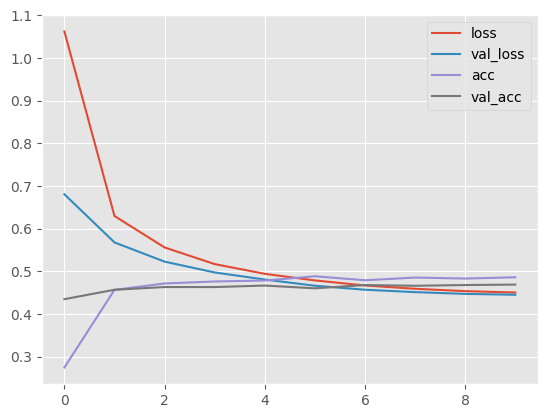

In [69]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# e = np.linspace(1, EPOCHS, num=EPOCHS)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.plot(r.history['depth_acc'], label='acc')
plt.plot(r.history['val_depth_acc'], label='val_acc')

plt.legend()
plt.show()

# Evaluation

In [ ]:
img_dm_pairs = pd.read_csv("/home/ajay/MDE/data/nyu2_test.csv")
labels = {i: j for i,j in img_dm_pairs}
test_paths = [i for i,j in img_dm_pairs]
print(len(test_paths))
partition = {'test': test_paths}

x_test = np.empty((len(test_paths), HEIGHT, WIDTH, 3))
y_test = np.empty((len(test_paths), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['test'][:]):
    x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
    y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)
print(model.evaluate(x_test, y_test))

In [51]:
img_dm_pairs = pd.read_csv("/home/ajay/MDE/data/nyu2_test.csv",header=None)
a = img_dm_pairs[0]
b = img_dm_pairs[1]
labels = dict(zip(a,b))
test_paths = [i for i in img_dm_pairs[0]]
print(len(test_paths))
partition = {'test': test_paths}
#print(partition)

x_test = np.empty((len(test_paths), HEIGHT, WIDTH, 3))
y_test = np.empty((len(test_paths), HEIGHT, WIDTH, 1))

for i, ID in enumerate(partition['test'][:]):
    x_test[i, ] = preprocess_image(ID, horizontal_flip=False)
    y_test[i, ] = preprocess_depth_map(labels[ID], horizontal_flip=False)
print(model.evaluate(x_test, y_test))

654


2023-04-30 09:39:36.103317: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 602726400 exceeds 10% of free system memory.
2023-04-30 09:39:37.869857: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 602726400 exceeds 10% of free system memory.


21/21 [==============================] - 4s 113ms/step - loss: 0.2362 - depth_acc: 0.3594
[0.2362288236618042, 0.35937583446502686]


In [52]:
def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}
data = extract_zip('/home/ajay/nyu_test.zip')
    
rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
depth = np.load(BytesIO(data['eigen_test_depth.npy']))
crop = np.load(BytesIO(data['eigen_test_crop.npy']))

In [53]:
from matplotlib.patches import BoxStyle
def compute_errors(gt, pred):
    eps = 1e-9 #to keep values below 1
    thresh = np.maximum((gt / (pred+eps)), (pred / (gt+eps)))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt - pred) / (gt+eps))
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    log_10 = (np.abs(np.log10(gt+eps)-np.log10(pred+eps))).mean()
    return a1, a2, a3, abs_rel, rmse, log_10

def DepthNorm(x, maxDepth):
    return maxDepth / x

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []
    
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )
        print(output_shape.shape)
    return np.stack(scaled)

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=1000), minDepth, maxDepth) / maxDepth

def evaluate(model, rgb, depth, crop, batch_size=6, verbose=False):
    N = len(rgb)
    bs = batch_size
    predictions = []
    testSetDepths = []

    
 #Compute results
    for i in range(N//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        x = tf.image.resize(x, [240, 320])
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        true_y = np.expand_dims(true_y, -1)
        true_y = tf.image.resize(true_y, [240,320]) 
        true_y = true_y/10
        ##pred_y = scale_up(1, predict(model, x/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        pred_y = (model.predict(x/255, batch_size=bs))#*10
        pred_y = np.clip(pred_y, a_min=0.09, a_max=None)
        #pred_y = np.clip(DepthNorm(pred_y, maxDepth=1000), 10, 1000) / 1000

        # Test time augmentation: mirror image estimate
        ##pred_y_flip = scale_up(1, predict(model, x[...,::-1,:]/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        pred_y_flip = (model.predict(x[...,::-1,:]/255, batch_size=bs))#*10
        pred_y_flip = np.clip(pred_y_flip, a_min=0.09, a_max=None)
        #pred_y_flip = np.clip(DepthNorm(pred_y_flip, maxDepth=1000), 10, 1000) / 1000

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append((0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(true_y[j])

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)
    return e, true_y, pred_y, pred_y_flip,x

In [ ]:
evaluate(model, rgb, depth, crop, batch_size=6, verbose=False)

In [119]:
e, true_y, pred_y, pred_y_flip,akr = x

In [ ]:
pred_yy = np.clip(pred_y, a_min=0.001, a_max=None)
pred_yy

In [122]:
print(np.max(pred_yy), np.min(pred_yy), np.max(pred_y), np.min(pred_y))
print(np.max(true_y), np.min(true_y))

0.81942487 0.09 0.81942487 0.09
0.99783576 0.076673195


In [ ]:
from datetime import datetime
input_img = (480,480, 3)
model = UNet(input_img, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('ucheck111.h5', save_best_only=True, verbose=1)

#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 70
    base_lr =  0.0002
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

csv_log1111 = tf.keras.callbacks.CSVLogger('my_log1111.csv',separator = ',',append=False)

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint ,early_stop,csv_log1] #reduce_lr, early_stopping]
#model.CompileAndSummarizeModel(model = model)
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
start=datetime.now()
history = model.fit(train_generator, validation_data=val_generator, epochs= 60 ,callbacks=callbacks)
stop=datetime.now()
print(stop-start)
model.save('unet1111.h5')